# Example
We will use the healthcare pipeline again as example. For now, we will look at the `DataCourruption` what-if analysis.

In [1]:
import os
from jenga.corruptions.numerical import Scaling
from example_pipelines import HEALTHCARE_PY
from example_pipelines.healthcare import custom_monkeypatching
from mlwhatif import PipelineAnalyzer
from mlwhatif.analysis._data_corruption import DataCorruption

def corruption(pandas_df):
    pandas_df['num_children'] = 0
    return pandas_df

data_corruption = DataCorruption({'income':
                                  lambda pandas_df: Scaling(column='income', fraction=1.).transform(pandas_df),
                                  'num_children': corruption},
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=True)

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .execute()

report = analysis_result.analysis_to_result_reports[data_corruption]

INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 3543.612003326416 ms
2022-07-21 13:02:54.910069: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 13:02:54.968029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
INFO:---RUNTIME: Original pipeline execution took 1161.7398262023926 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 5.366086959838867 ms

Let us start by looking at the report generated by the analysis.

In [2]:
report

column  corruption_percentage  metric_corrupt_test_only  \
0        income                    0.3                  0.863014   
1        income                    0.6                  0.589041   
2        income                    0.9                  0.452055   
3  num_children                    0.3                  0.917808   
4  num_children                    0.6                  0.917808   
5  num_children                    0.9                  0.945205   

   metric_corrupt_train_and_test:  
0                        0.931507  
1                        0.945205  
2                        0.452055  
3                        0.917808  
4                        0.958904  
5                        0.904110

To help us to understand what is going on, let us use some convenience functions to save the intermediate DAGs mlwhatif uses internally.

In [3]:
from mlwhatif.utils import get_project_root

INTERMEDIATE_EXTRACTION_ORIG_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "data_corruption-orig")
INTERMEDIATE_EXTRACTION_GENERATED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "data_corruption-what-if")
INTERMEDIATE_EXTRACTION_OPTIMISED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "data_corruption-what-if-optimised")

def corruption(pandas_df):
    pandas_df['num_children'] = 0
    return pandas_df

data_corruption = DataCorruption({'income':
                                  lambda pandas_df: Scaling(column='income', fraction=1.).transform(pandas_df),
                                  'num_children': corruption},
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=True)

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .save_original_dag_to_path(INTERMEDIATE_EXTRACTION_ORIG_PATH) \
    .save_what_if_dags_to_path(INTERMEDIATE_EXTRACTION_GENERATED_PATH) \
    .save_optimised_what_if_dags_to_path(INTERMEDIATE_EXTRACTION_OPTIMISED_PATH) \
    .execute()

report = analysis_result.analysis_to_result_reports[data_corruption]

INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 6.870031356811523 ms
INFO:---RUNTIME: Original pipeline execution took 1046.802043914795 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 4.726171493530273 ms
INFO:Performing Multi-Query Optimization
INFO:Estimated runtime of original DAG is 977.8130054473877ms
INFO:Estimated unoptimized what-if runtime is 11733.756065368652ms
INFO:Estimated optimised what-if runtime is 7068.636178970337ms
INFO:Estimated optimisation runtime saving is 4665.119886398315ms
INFO:---RUNTIME: Multi-Query Optimization took 11.52801513671875 ms
INFO:Executing generated plan
INFO:---RUNTIME: Execution took 6649.125099182129 ms
INFO:Done!


Let us now look at the original pipeline DAG.

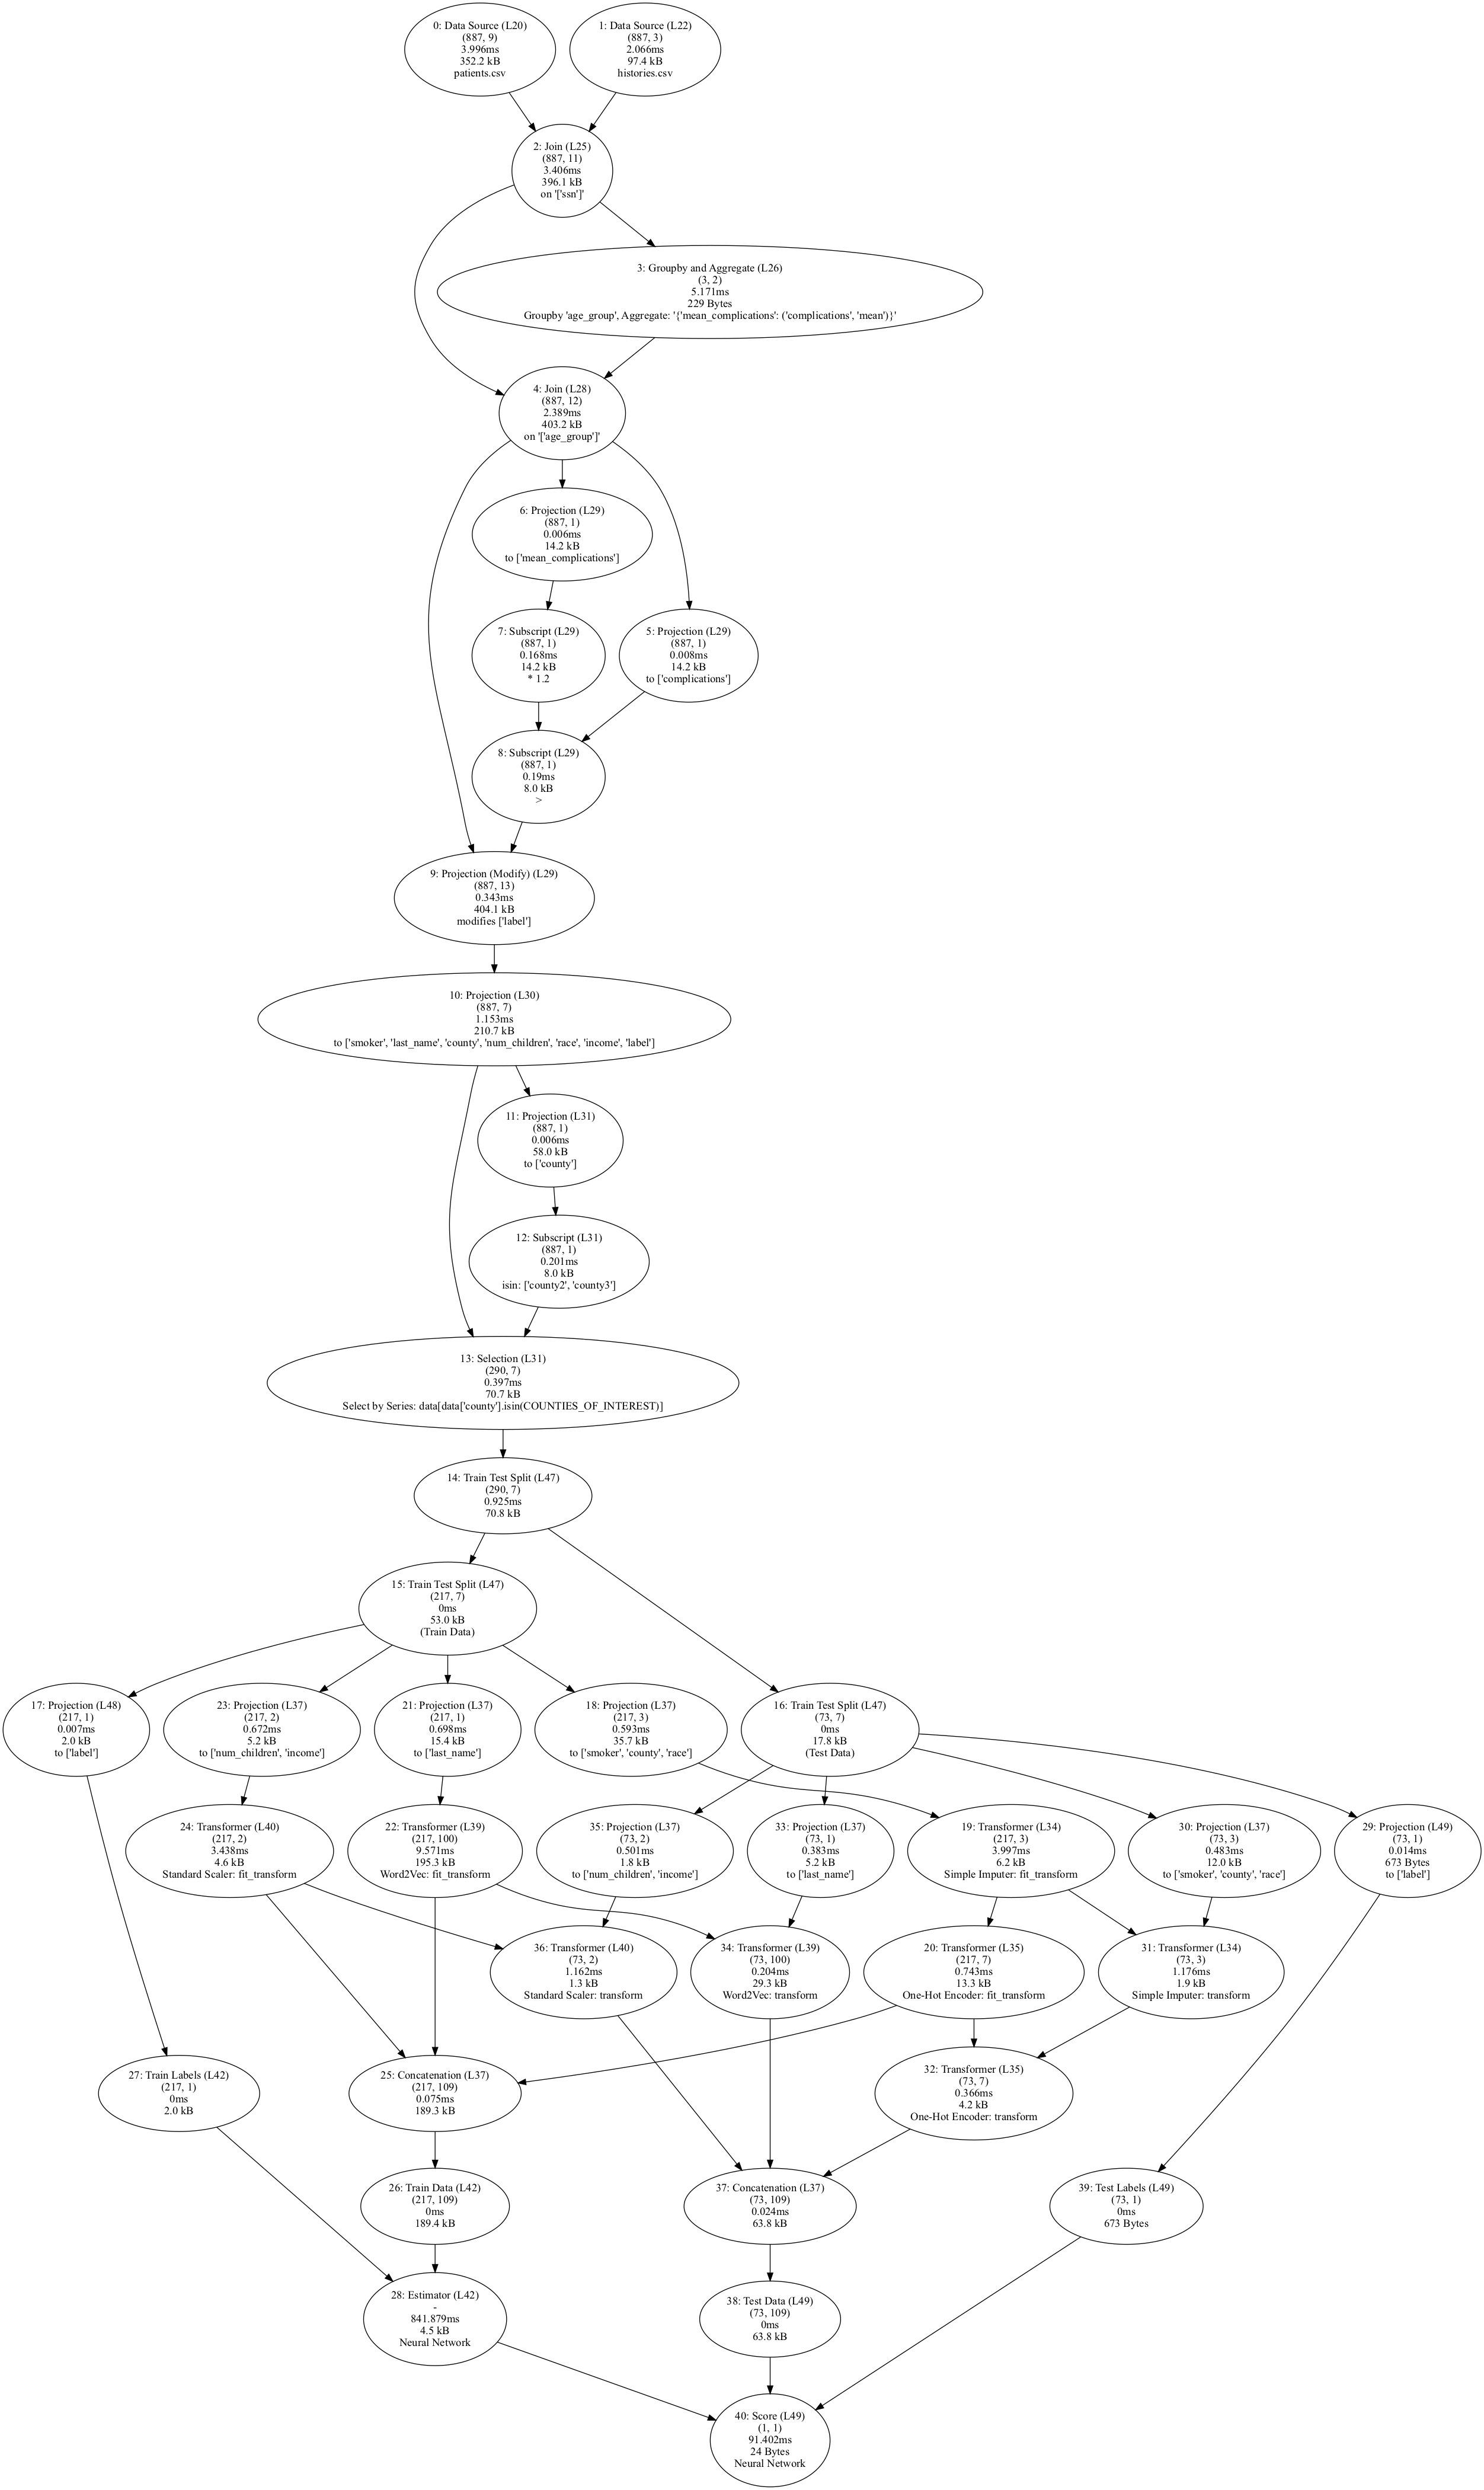

In [4]:
from IPython.display import Image
Image(filename=f"{INTERMEDIATE_EXTRACTION_ORIG_PATH}.png")

This pipeline DAG then gets rewritten to several DAGs we need for our analysis. Let us look at an example. Note the corruption operation now present in the DAG.

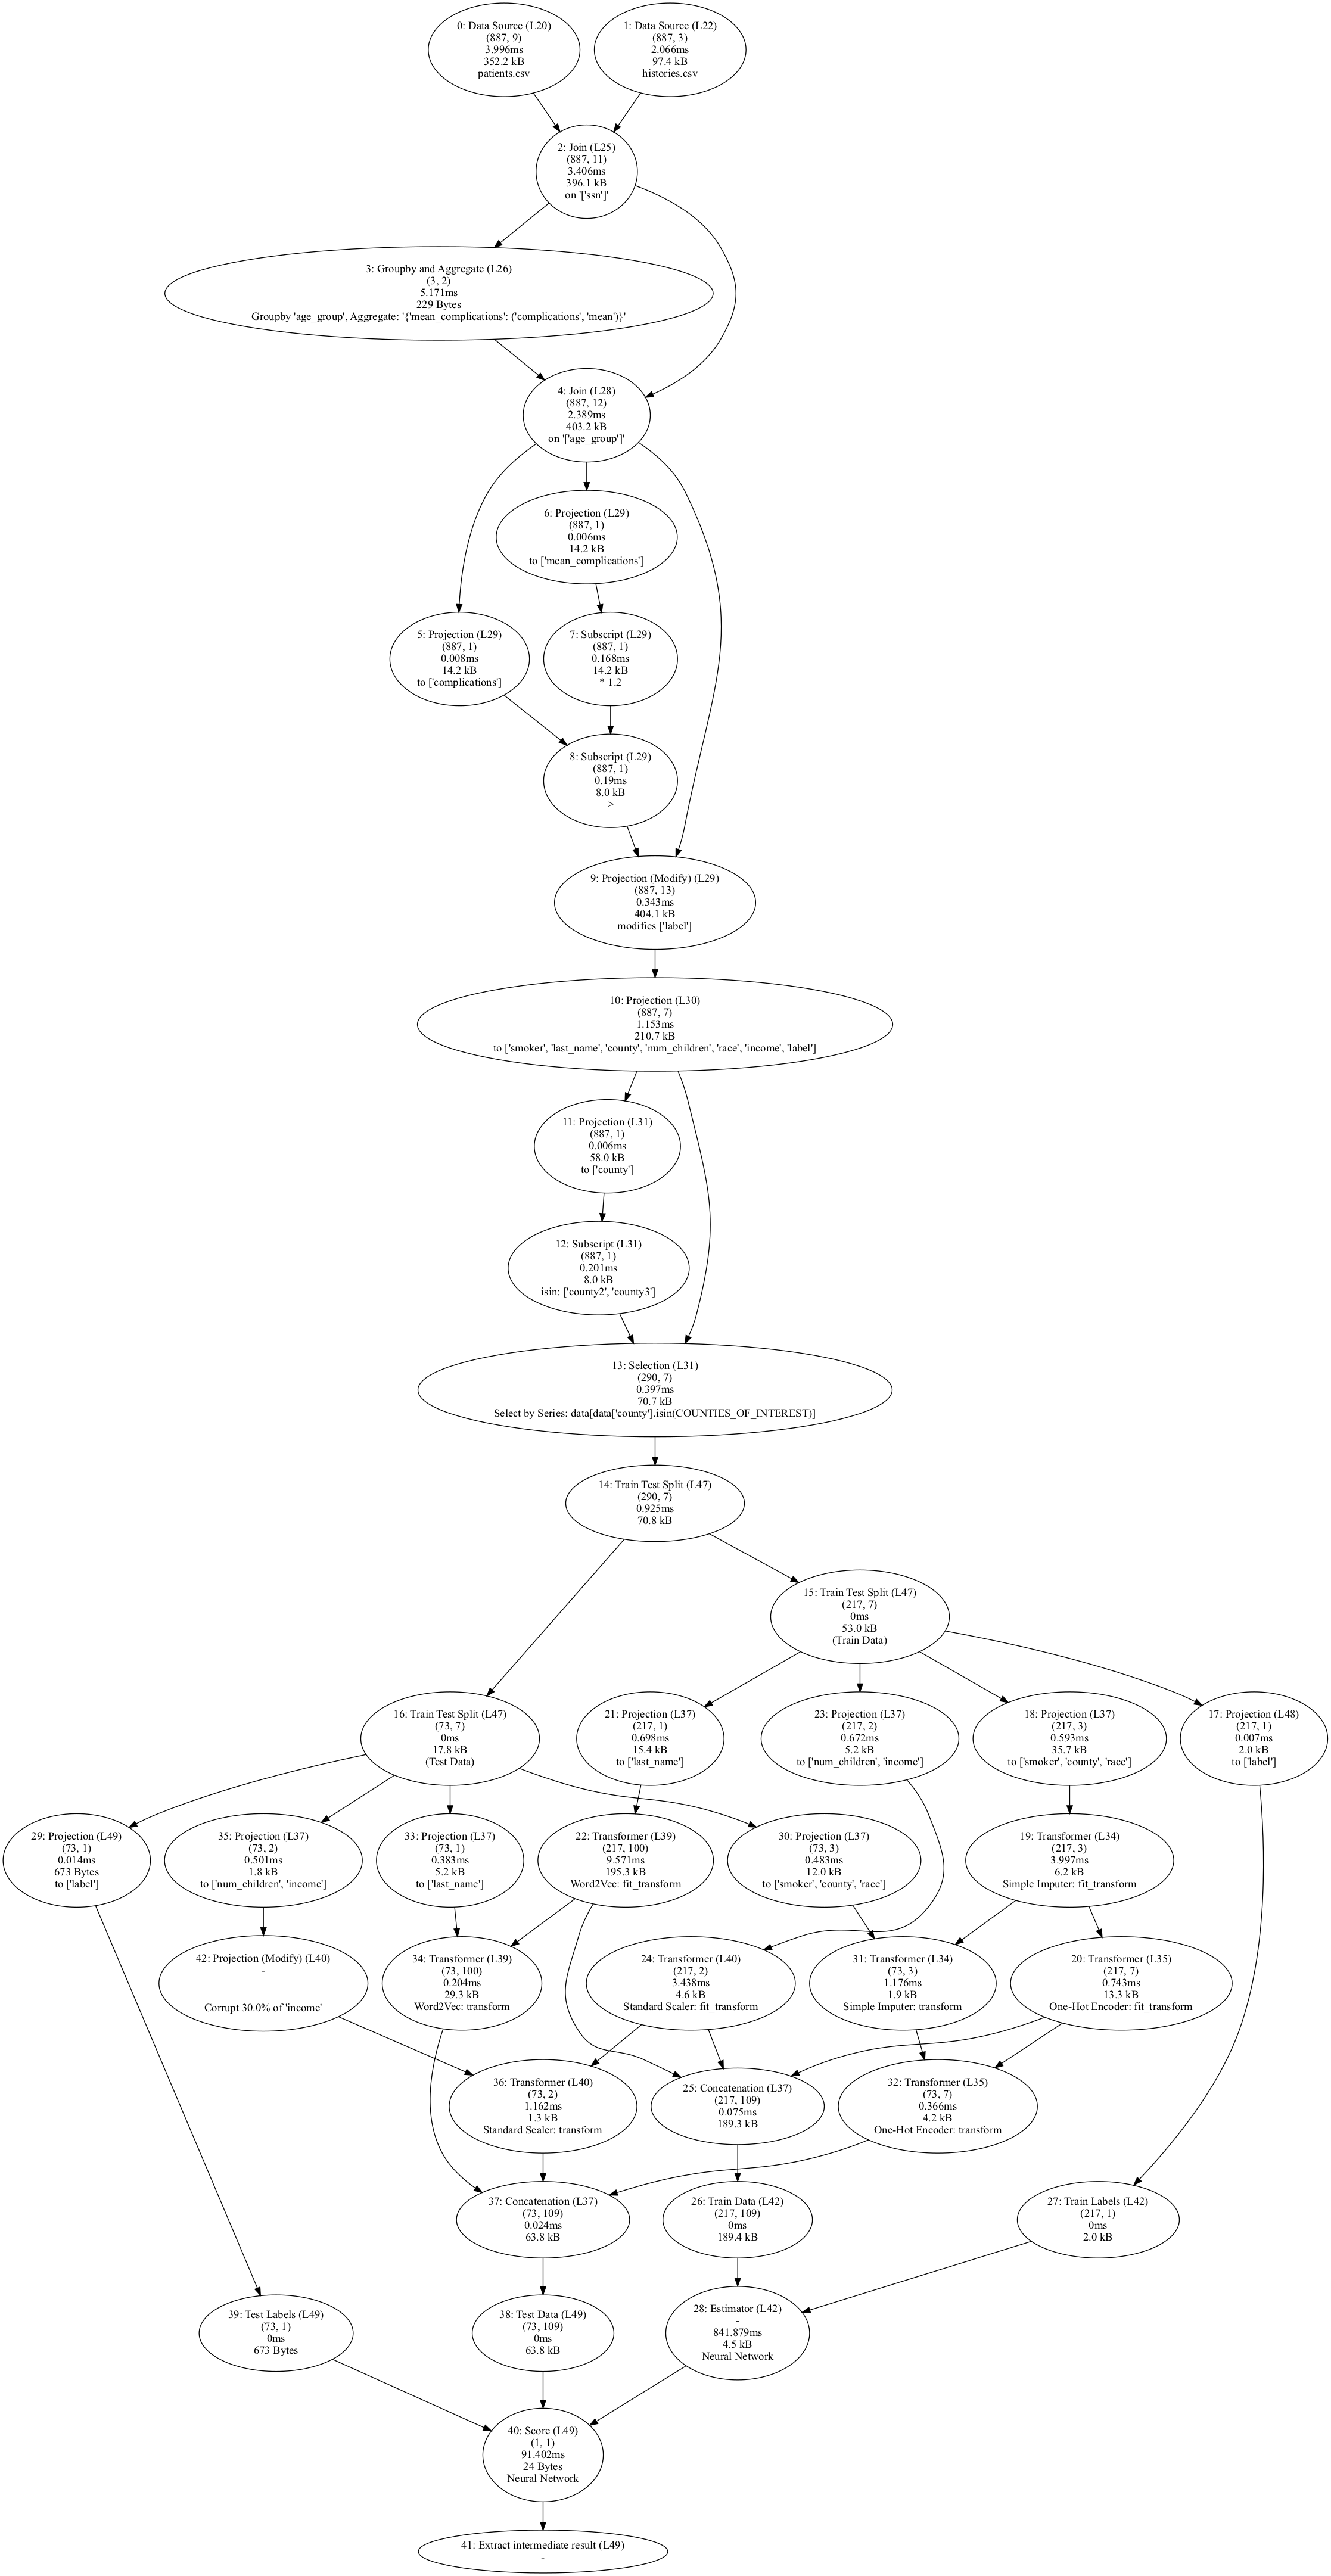

In [5]:
Image(filename=f"{INTERMEDIATE_EXTRACTION_GENERATED_PATH}-DataCorruption-0.png")

We then use a multi-query optimizer to combine all the generated DAGs for efficient execution.

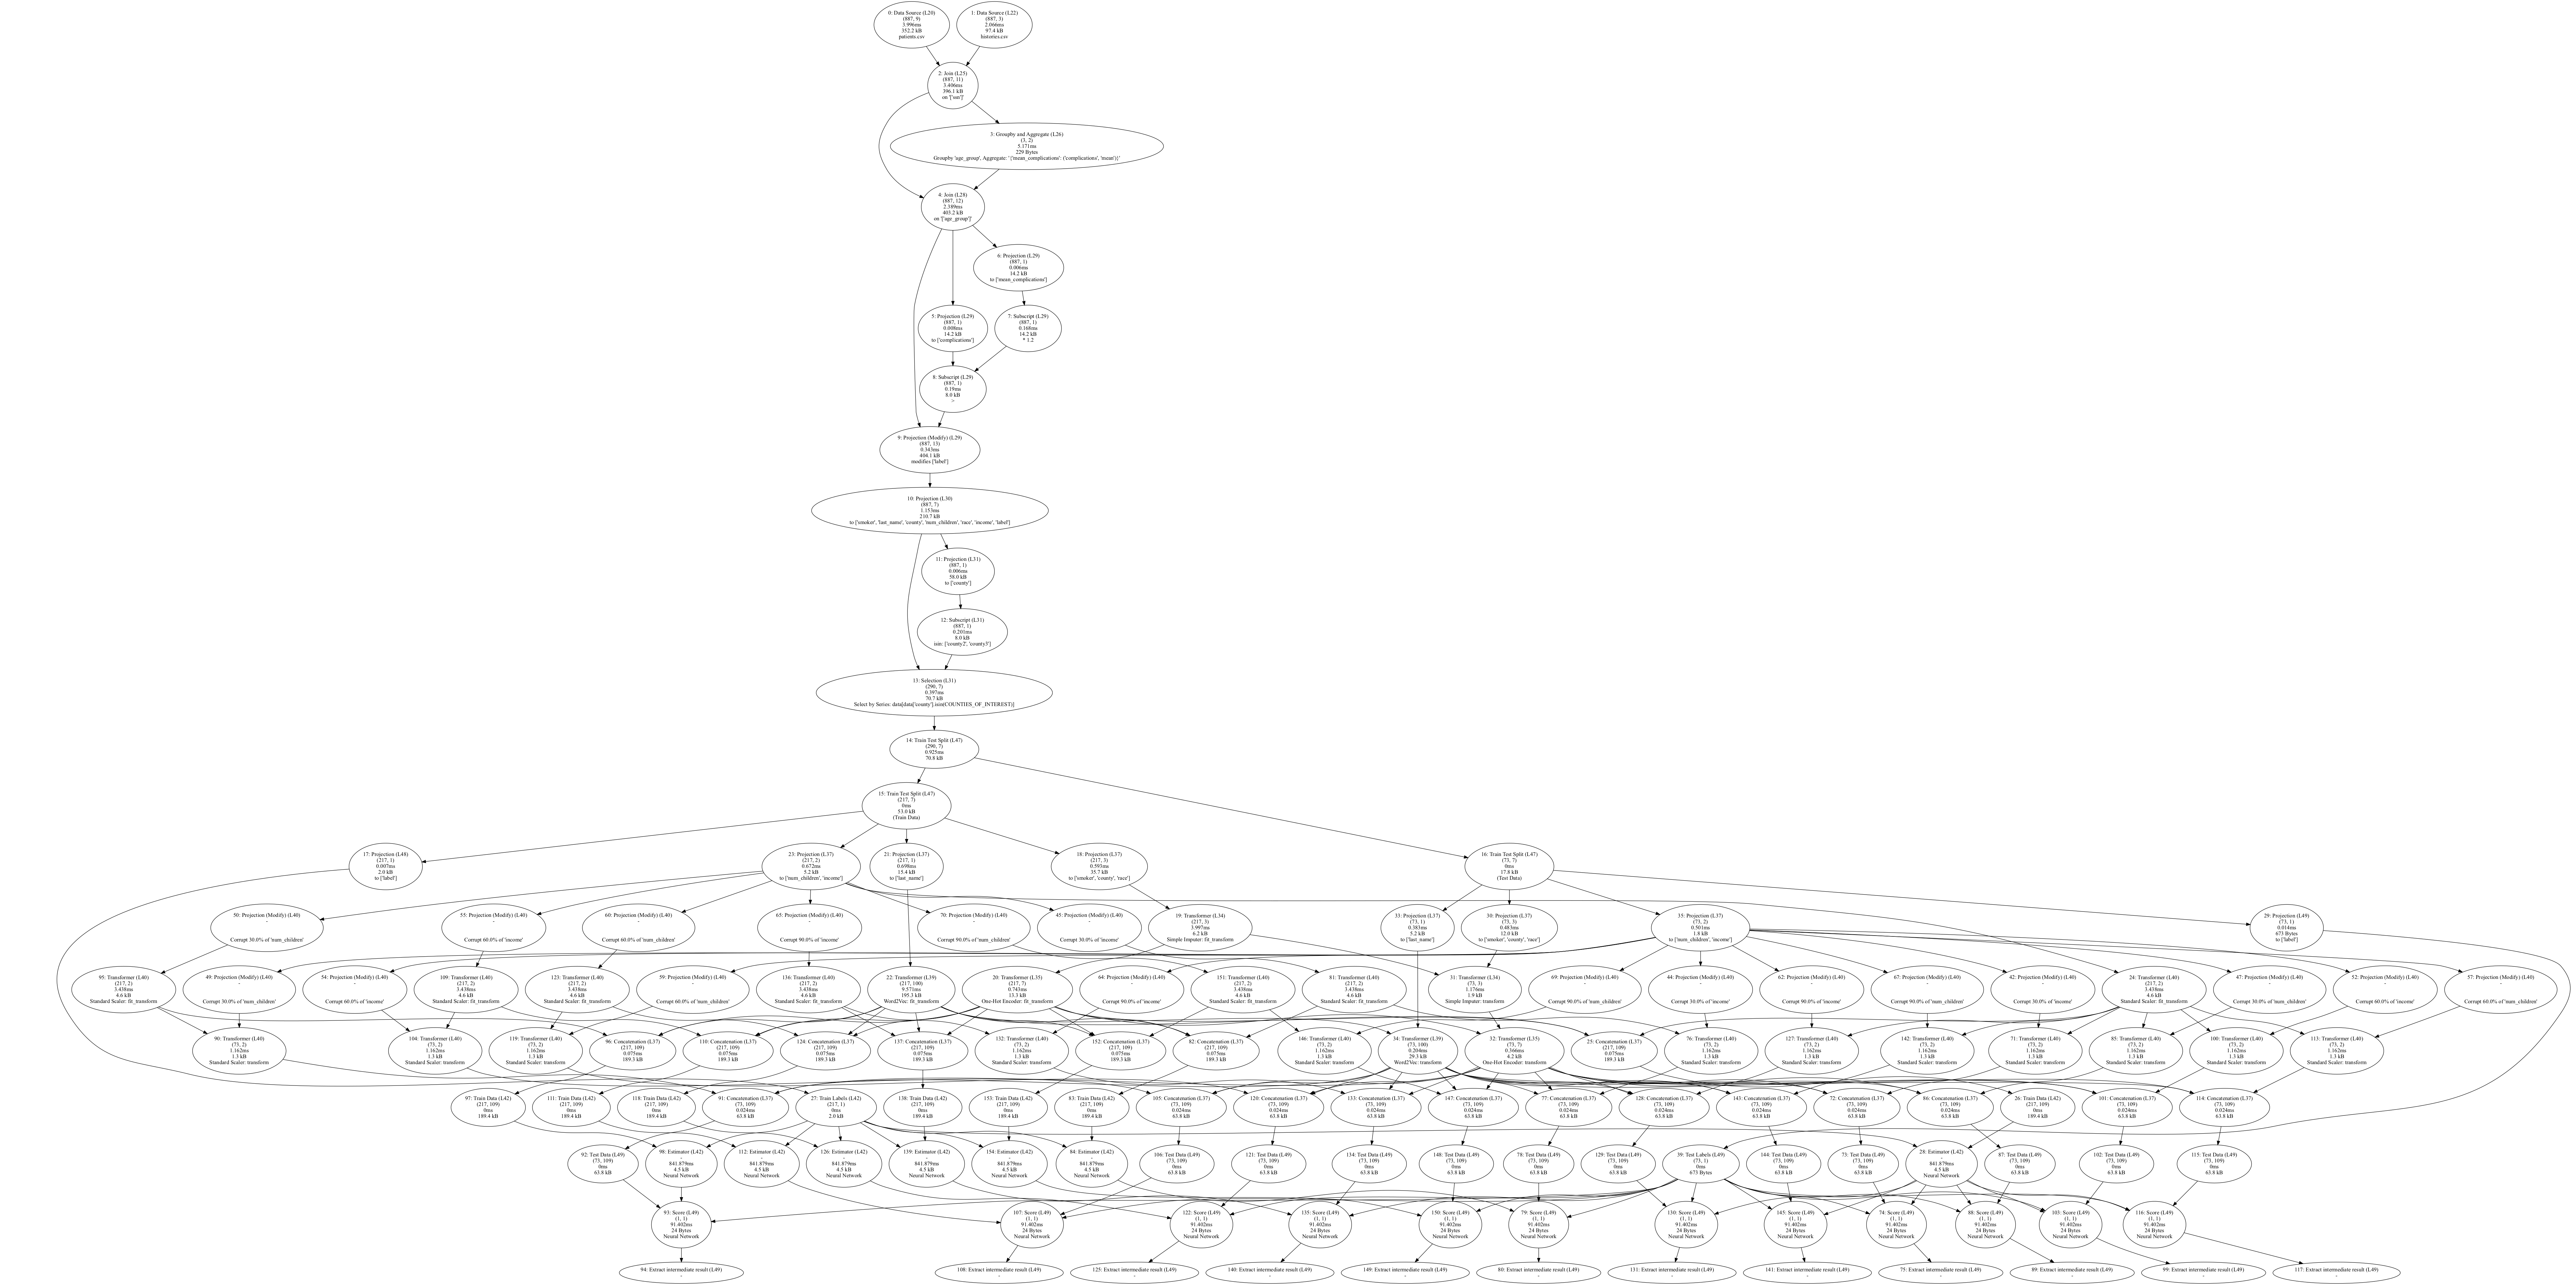

In [6]:
Image(filename=f"{INTERMEDIATE_EXTRACTION_OPTIMISED_PATH}.png")

Let us take a look at how long our analysis takes without this multi-query optimizer.

In [7]:
analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(True) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .execute()

INFO:The skip_multi_query_optimization function is only intended for benchmarking!
INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 6.313085556030273 ms
INFO:---RUNTIME: Original pipeline execution took 1066.2989616394043 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 5.159139633178711 ms
INFO:Executing generated plans
INFO:---RUNTIME: Execution took 13014.472961425781 ms
INFO:Done!


Let us now look at a scenario where we only need to introduce corruptions in the test set, where we do not have model retraining that we cannot optimise away. We can compare without query optimisation...

In [8]:
test_only_data_corruption = DataCorruption({'income':
                                  lambda pandas_df: Scaling(column='income', fraction=1.).transform(pandas_df),
                                  'num_children': corruption},
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=False)

fast_analysis_result_unopt = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(True) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(test_only_data_corruption) \
    .execute()

INFO:The skip_multi_query_optimization function is only intended for benchmarking!
INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 6.976842880249023 ms
INFO:---RUNTIME: Original pipeline execution took 1090.5482769012451 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 4.796028137207031 ms
INFO:Executing generated plans
INFO:---RUNTIME: Execution took 6199.105739593506 ms
INFO:Done!


... and with query optimisation.

In [9]:
fast_analysis_result_opt = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(False) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(test_only_data_corruption) \
    .execute()

INFO:The skip_multi_query_optimization function is only intended for benchmarking!
INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 5.690097808837891 ms
INFO:---RUNTIME: Original pipeline execution took 1086.6408348083496 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 4.065990447998047 ms
INFO:Performing Multi-Query Optimization
INFO:Estimated runtime of original DAG is 1019.7436809539795ms
INFO:Estimated unoptimized what-if runtime is 6118.462085723877ms
INFO:Estimated optimised what-if runtime is 1643.3167457580566ms
INFO:Estimated optimisation runtime saving is 4475.14533996582ms
INFO:---RUNTIME: Multi-Query Optimization took 6.658077239990234 ms
INFO:Executing generated plan
INFO:---RUNTIME:

The results from the optimised and unoptimised execution are the same, only the randomness involved in model training, which are also present when re-executing the same pipeline multiple times, might lead to minor differences.

In [10]:
fast_report_opt = fast_analysis_result_opt.analysis_to_result_reports[test_only_data_corruption]
fast_report_opt

column  corruption_percentage  metric_corrupt_test_only
0        income                    0.3                  0.835616
1        income                    0.6                  0.684932
2        income                    0.9                  0.479452
3  num_children                    0.3                  0.904110
4  num_children                    0.6                  0.904110
5  num_children                    0.9                  0.904110

In [11]:
fast_report_unopt = fast_analysis_result_unopt.analysis_to_result_reports[test_only_data_corruption]
fast_report_unopt

column  corruption_percentage  metric_corrupt_test_only
0        income                    0.3                  0.753425
1        income                    0.6                  0.726027
2        income                    0.9                  0.506849
3  num_children                    0.3                  0.890411
4  num_children                    0.6                  0.972603
5  num_children                    0.9                  0.931507